In [1]:
"""
This notebook explores the relationship between the amenities available near a home and its price.
"""

%pip install -q pandas matplotlib seaborn
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


entertainment_count    0.029732
grocery_count          0.180778
hospitals_count        0.102375
parks_count            0.051907
school_count           0.035426
shopping_count         0.167311
university_count      -0.049487
waterfront_count       0.014236
Name: Price, dtype: float64


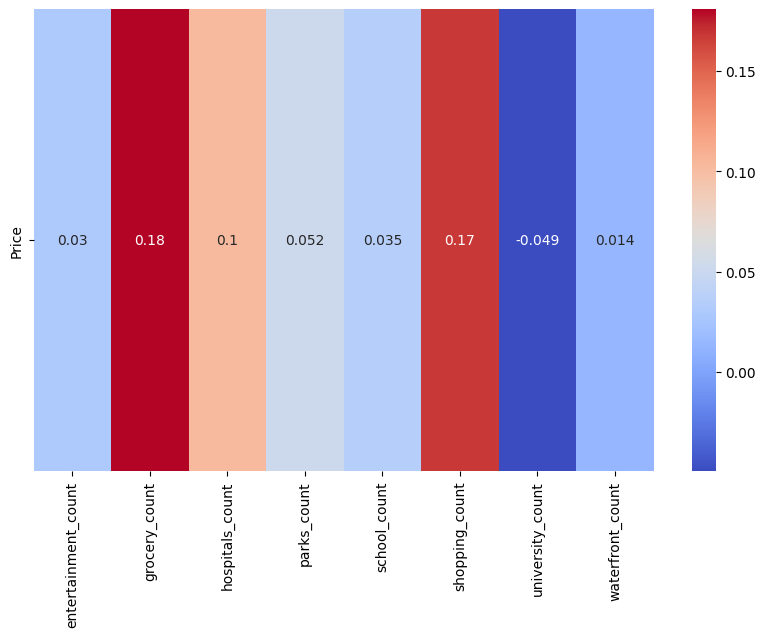

In [ ]:
# Load data into a DataFrame
df = pd.read_csv('../csvs/DA_summary_counts.csv')
df = df.rename(columns={'Residential_TotalGross_Average': 'Price'})
numeric_columns = df.select_dtypes(include="number")
corr_with_price = numeric_columns.corr()['Price'].drop('Price').drop('DAUID')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_with_price.to_frame(), annot=True, cmap="coolwarm")

print(corr_with_price)

AttributeError: Rectangle.set() got an unexpected keyword argument 'annot'

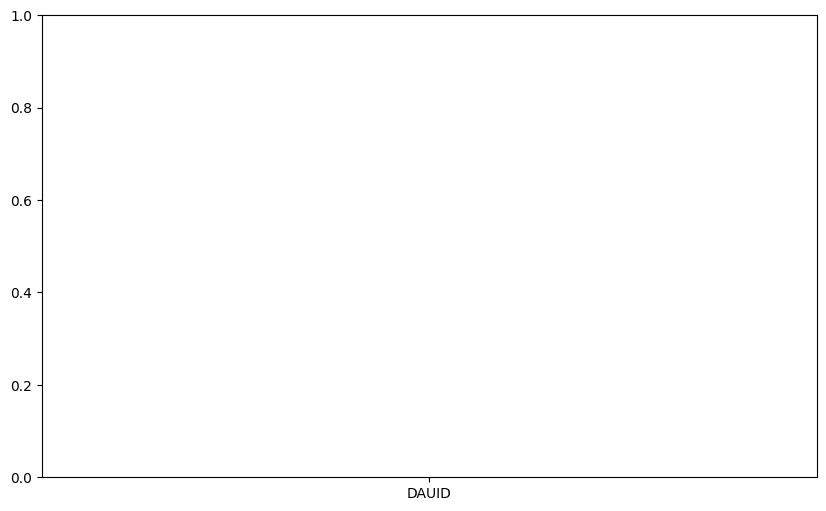